### **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
warnings.filterwarnings("ignore")

### **Reading Data**

In [2]:
df = pd.read_csv('SMSSpamCollection', sep='\t',names=['Label','Message'])
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### **Exploratory Data Analysis**

In [3]:
df.info() # Information About data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.describe() # Description of data

,Label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Text(0.5, 1.0, 'Number of Ham and Spam messages')

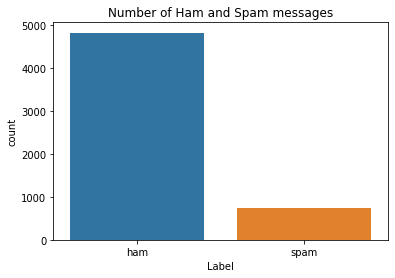

In [5]:
### Target class distribution
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of Ham and Spam messages')

> Target class is imbalance and is biased towards the Ham Label (Not Spam)

### **Pre-Processing**

In [6]:
### Separating feature Message and the target Label
X = df.Message 
Y = df.Label

### As target label is categorical so label encoding it
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [7]:
### Splitting the data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15) # Reserving 15% for testing

In [9]:
### Tokenizing the messages
words = 1000
length = 150 # For padding
tokenizer = Tokenizer(num_words = words)
tokenizer.fit_on_texts(X_train)

### Adding padding so that each message should have same length
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = length)

### **Deep Learning Model**

> #### Model Architecture

In [10]:
inputs = Input(shape = [length])
x = Embedding(words, 50, input_length=length)(inputs)
x = LSTM(64)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)
model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257   

> #### Model Compilation

In [11]:
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])

> #### Training

In [12]:
history = model.fit(sequences_matrix, Y_train, batch_size = 128, epochs = 10, validation_split = 0.2, 
                    callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001)])

Epoch 1/10
30/30 [==============================] - 9s 186ms/step - loss: 0.3468 - accuracy: 0.8672 - val_loss: 0.1402 - val_accuracy: 0.9599
Epoch 2/10
30/30 [==============================] - 6s 217ms/step - loss: 0.0910 - accuracy: 0.9781 - val_loss: 0.0578 - val_accuracy: 0.9821


> #### Testing and Evaluation

In [13]:
### Preparing Test Data

test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen = length)

In [15]:
### Accuracy & Loss
acc = model.evaluate(test_sequences_matrix, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0], acc[1]))

27/27 [==============================] - 0s 17ms/step - loss: 0.0701 - accuracy: 0.9821
Test set
  Loss: 0.070
  Accuracy: 0.982


> Model is giving 98% accuracy on test data